In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# 데이터 업로드
from google.colab import files
uploaded = files.upload()

Saving 202501.xlsx to 202501.xlsx


In [2]:
# 데이터 불러오기
df = pd.read_excel('202501.xlsx')

In [3]:
# 금속 농도 열 추출 (단위가 ng/m3인 열)
metal_columns = df.columns[df.columns.str.endswith('(ng/m3)')]

# 날짜 추출
df['Date'] = pd.to_datetime(df['Pump-Begin']).dt.date

In [8]:
# 이상치 제거 (NaN, 음수, 0은 결측 처리)
for col in metal_columns:
    df[col] = df[col].apply(lambda x: x if pd.notna(x) and x > 0 else pd.NA)

In [9]:
# 날짜별 금속 농도 합계 계산
daily_metal_sum = df.groupby('Date')[metal_columns].sum()

print(daily_metal_sum.head())

           Al(ng/m3) Si(ng/m3)   S(ng/m3) K(ng/m3) Ca(ng/m3) Ti(ng/m3)  \
Date                                                                     
2025-01-10   6467.68   9129.44   26630.57  3169.75   1549.33      5.46   
2025-01-11  10849.28  17949.95   87858.83  5597.79   2694.73      6.86   
2025-01-12  11107.79  19625.39   93425.85   6384.6   3029.76     12.52   
2025-01-13  13024.65  26825.96   109464.1  6752.01   3251.99     19.76   
2025-01-14  17458.61   50810.0  132868.98   9171.9   4928.67     83.86   

           V(ng/m3) Cr(ng/m3) Mn(ng/m3) Fe(ng/m3)  ... Cd(ng/m3) In(ng/m3)  \
Date                                               ...                       
2025-01-10    50.53      73.3    113.26   1195.49  ...   3858.23    682.87   
2025-01-11   103.57    115.42    208.62   2878.73  ...   6935.55   1128.51   
2025-01-12   100.87    114.01    210.77   2643.23  ...   6857.37    1105.5   
2025-01-13    82.22    100.23    220.69    3030.9  ...   6294.95    947.43   
2025-01-14   

In [5]:
# 날짜별 전체 금속 농도 총합 계산 (이상치 기준용)
total_sum = daily_metal_sum.sum(axis=1)

print(total_sum.head())

Date
2025-01-10     60980.76
2025-01-11    149442.19
2025-01-12    157006.71
2025-01-13    180696.59
2025-01-14    236255.37
dtype: float64


In [10]:
# 이상치 판정: 전체 금속 농도 총합 기준 (평균보다 1.5배 이상인 경우)
threshold_total = total_sum.mean() + 1.5 * total_sum.std()
outlier_dates = total_sum[total_sum > threshold_total].index.tolist()

print(outlier_dates)

[datetime.date(2025, 1, 21), datetime.date(2025, 1, 23)]


In [11]:
# 일별 금속 농도 비율 (%) 계산 (그래프용)
combined_days_sorted = daily_metal_sum.sort_index() # 날짜 정렬
combined_percentage = combined_days_sorted.div(combined_days_sorted.sum(axis=1), axis=0) * 100

# 결과 출력
print(combined_percentage.head())

            Al(ng/m3)  Si(ng/m3)   S(ng/m3)  K(ng/m3) Ca(ng/m3) Ti(ng/m3)  \
Date                                                                        
2025-01-10  10.596738  14.957803  43.631902  5.193363  2.538444  0.008946   
2025-01-11    7.25365  12.001041  58.740968   3.74259  1.801652  0.004586   
2025-01-12   7.063964  12.480705  59.413877  4.060266  1.926766  0.007962   
2025-01-13    7.19791  14.825032  60.493971  3.731414  1.797172   0.01092   
2025-01-14   7.383876  21.489383  56.195088  3.879128  2.084512  0.035467   

            V(ng/m3) Cr(ng/m3) Mn(ng/m3) Fe(ng/m3)  ... Cd(ng/m3) In(ng/m3)  \
Date                                                ...                       
2025-01-10  0.082789  0.120096  0.185567  1.958708  ...  6.321379  1.118824   
2025-01-11  0.069245  0.077168   0.13948  1.924671  ...  4.636995  0.754503   
2025-01-12  0.064148  0.072504  0.134039  1.680954  ...  4.360923  0.703039   
2025-01-13  0.045438  0.055391  0.121962  1.674989  ...  3.478826

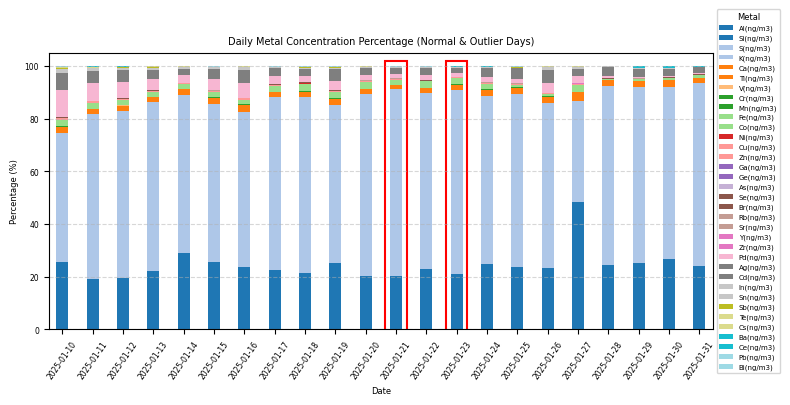

In [12]:
# 날짜 리스트
dates = combined_percentage.index.tolist()

# 그래프 생성
fig, ax = plt.subplots(figsize=(8, 4))
combined_percentage.plot(kind='bar',
                         stacked=True,
                         ax=ax,
                         width=0.4,
                         colormap='tab20')

# 이상치 날짜 표시
for i, date in enumerate(dates):
    if date in outlier_dates:
        rect = patches.Rectangle((i - 0.35, -2), # 박스 시작 위치
                                 0.7, # 박스 가로 길이
                                 104, # 박스 높이
                                 linewidth=1.5, # 선 굵기
                                 edgecolor='red',
                                 facecolor='none')
        ax.add_patch(rect) # 도형 표시

# 그래프 기본 설정
plt.title("Daily Metal Concentration Percentage (Normal & Outlier Days)", fontsize=7)
plt.xlabel("Date", fontsize=6)
plt.ylabel("Percentage (%)", fontsize=6)
plt.xticks(rotation=55, fontsize=5.5)
plt.yticks(fontsize=5.5)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 범례 설정
plt.legend(loc='center left',
           bbox_to_anchor=(1.0, 0.5),
           fontsize=5,
           title='Metal',
           title_fontsize=6)

# 레이아웃 자동 조절
plt.tight_layout()

# 결과 출력
plt.show()